# Multiview ball extrinsic calibration
Pre-request, you have run step1 intrinsic calibration. The `intrinsics_calib_carl.json` is previous outcome.

In [2]:
# import the necessary packages
import pickle
import numpy as np
import json

intrinsics_json = 'intrinsics_calib_carl.json'

## The input ball location data format
The ball position in all view is stored in a `keypoints` variable, which is (NVIEW, NSAMPLE, NKEYPOINT=1, XYP=3).

And the `P` in `XYP` is **0<=P<=1**, means the reliable of this detection. If you failed to detect a ball sometimes in a view, just set the `XY=np.nan`, and `P=0` for **IVIEW**. The `P` will be cutoff around `0.7` to auto delete reliable ball detections.

In [3]:
matfile = 'demo_data/2023-05-30_13-50-17carlball.matpkl'
matdata = pickle.load(open(matfile, 'rb'))
assert 'keypoints' in matdata.keys()

print(matdata['keypoints'].shape) #(NVIEW, NSAMPLE, NKEYPOINT=1, xyp=3)
print(matdata['info'])            # The grid video. If you video is not grid. Just keep 'nview', 'fps' is required
print(matdata['views_xywh'])      # (NVIEW, 4) x,y,w,h. If you video is not grid in mycase, you just set x=0,y=0

(9, 12825, 1, 3)
{'vfile': '/mnt/liying.cibr.ac.cn_Data_Temp/multiview_9/chenxf/carl/paper_video/2023-05-30_13-50-17carlball.mp4', 'nview': 9, 'fps': 30.0}
[[0, 0, 1280, 800], [1280, 0, 1280, 800], [2560, 0, 1280, 800], [0, 800, 1280, 800], [1280, 800, 1280, 800], [2560, 800, 1280, 800], [0, 1600, 1280, 800], [1280, 1600, 1280, 800], [2560, 1600, 1280, 800]]


## Create a multiview tree
Here is to set the `connectivity` between cameras. Give the hint which pairs of cameras are likely share/(connectivity) most views field of ball. In general case, all cameras share most common view field. You can use default config. 

For example, `0` share with `2`, `0` not with `1`, `1` share with `2`. You can set `"minimal_tree":{[0, 1], [1, 2]}` to global connection.

Note that this `connectivity` define only works when calibration, and won't affect next step 2D<->3D transfrom.


In [4]:
nview=9
minimal_tree = [[i,i+1] for i in range(nview-1)]
setup_dict = {"views": list(range(nview)),
              "minimal_tree": minimal_tree}
setup_json = 'setup.json'
json.dump(setup_dict, open(setup_json, 'w'), indent=4)
print(setup_dict)

{'views': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'minimal_tree': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]}


## Downsample the ball sample to <=1000
It will do
- Downsample ball sample to 1000
- Pack all nessary informtion into one file

In [5]:
from matpkl2ballpkl import convert as convert_matpkl2ballpkl

convert_matpkl2ballpkl(matfile, intrinsics_json, setup_json)

Video file demo_data/2023-05-30_13-50-17carlball.mp4 does not exist
python -m lilab.multiview_scripts_dev.s3_ballpkl2calibpkl demo_data/2023-05-30_13-50-17carlball.ballpkl


'demo_data/2023-05-30_13-50-17carlball.ballpkl'

## Content of `ballpkl`
- **setup**: copy from `setup.json`
- **intrinsics**: copy from `intrinsic_calib.json`
- **landmarks_move_xy**: downsample ball xy position, (NVIEW, 1000, XY)
- **background_img**: (NVIEW, )x(H,W,3) numpy array for background image each view, default not set
- *landmarks_global_xy*, *landmarks_global_cm*, *global_iframe*: obsoleted


In [6]:
ballpklfile = matfile.replace('.matpkl', '.ballpkl')
ballpkl = pickle.load(open(ballpklfile, 'rb'))
print(ballpkl.keys())
print(ballpkl['landmarks_move_xy'].shape)

dict_keys(['landmarks_global_xy', 'landmarks_move_xy', 'global_iframe', 'landmarks_global_cm', 'background_img', 'setup', 'intrinsics'])
(9, 1000, 2)


## !! The most critical setup
## Multiview extrinsic calibration.
The main precessing is :
1. Pair each two pair cameras in the `setup.json/mini_tree`.
2. Concat all views. Get a rough relative pose.
3. Remove outlier samples. Use bundle ajustment to refine relative poses.

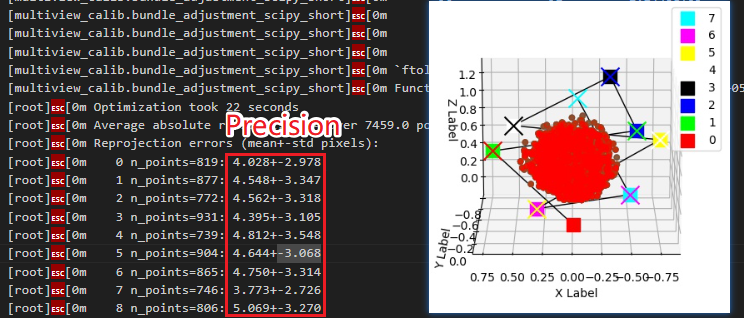

The outcome is `*.calibpkl` file.

In [7]:
from ballpkl2calibpkl import main_calibrate
calibpklfile = main_calibrate(ballpklfile, skip_global=True, skip_camera_intrinsic=True)

2023-06-04 16:05:47,543 [root] -------------------------------------------------
2023-06-04 16:05:47,545 [root] Computing robust relative pose for pair 0->1
2023-06-04 16:05:47,546 [root] Initial relative pose:
2023-06-04 16:05:47,564 [root] Computing relative pose of pair [0, 1]:
2023-06-04 16:05:47,566 [root] 	0 out of 726 points considered outliers.
2023-06-04 16:05:47,573 [root] 	Residual error: 4.192612034135649
2023-06-04 16:05:47,575 [root] 	Sampson distance: 15.01830272384412
2023-06-04 16:05:47,575 [root] Number of additional paths found: 5
2023-06-04 16:05:47,591 [root] 	Computing relative pose of pair [0, 2]:
2023-06-04 16:05:47,592 [root] 		0 out of 667 points considered outliers.
2023-06-04 16:05:47,599 [root] 		Residual error: 2.4055273793732908
2023-06-04 16:05:47,600 [root] 		Sampson distance: 5.658330088204435
2023-06-04 16:05:47,617 [root] 	Computing relative pose of pair [2, 1]:
2023-06-04 16:05:47,619 [root] 		0 out of 709 points considered outliers.
2023-06-04 16:0

Fixing camera instrincis!
Number of landmarks skipped because only visible in one view: 9


100%|██████████| 997/997 [00:00<00:00, 24340.49it/s]
2023-06-04 16:05:57,581 [root] The preparation of the input data took: 0.17s
2023-06-04 16:05:57,581 [root] Sizes:
2023-06-04 16:05:57,582 [root] 	 camera_params: (9, 15)
2023-06-04 16:05:57,583 [root] 	 points_3d: (988, 3)
2023-06-04 16:05:57,583 [root] 	 points_2d: (7448, 2)


Number of landmarks skipped because only visible in one view: 9


2023-06-04 16:05:57,907 [root] Early Outlier rejection:
2023-06-04 16:05:57,908 [root] 	 threshold outliers: 100
2023-06-04 16:05:57,924 [root] 	 Number of points considered outliers: 0
2023-06-04 16:05:58,494 [multiview_calib.bundle_adjustment_scipy_short]    Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality
2023-06-04 16:05:58,496 [multiview_calib.bundle_adjustment_scipy_short]        0              1         5.9371e+05                                    1.90e+09
2023-06-04 16:05:59,093 [multiview_calib.bundle_adjustment_scipy_short]        1              2         1.3408e+05      4.60e+05       2.47e-01       3.04e+07
2023-06-04 16:05:59,550 [multiview_calib.bundle_adjustment_scipy_short]        2              3         1.2115e+05      1.29e+04       1.70e-01       2.01e+07
2023-06-04 16:05:59,962 [multiview_calib.bundle_adjustment_scipy_short]        3              4         1.2033e+05      8.23e+02       5.60e-02       2.20e+06
2023-06-04 16:06:0

Number of landmarks skipped because only visible in one view: 9
Skipping global BA
python -m lilab.multiview_scripts_dev.s4_matpkl2matcalibpkl  demo_data/2023-05-30_13-50-17carlball.matpkl demo_data/2023-05-30_13-50-17carlball.calibpkl


## Content of the outcome `calibpkl` file
- **ba_poses**: all intrinsic & extrinsic parameters. `K` (3, 3), `dist`: (K1_K2_T1_T2_K3,), `t` (3,), `R` (3, 3)

In [8]:
calibpkl = pickle.load(open(calibpklfile, 'rb'))
print(calibpkl.keys())

print('ba_poses', calibpkl['ba_poses'])
calibpkl['ba_poses'][0]

dict_keys(['landmarks_global_xy', 'landmarks_move_xy', 'global_iframe', 'landmarks_global_cm', 'background_img', 'setup', 'intrinsics', 'ba_poses'])
ba_poses {0: {'R': [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], 't': [0.011150013583434749, 0.0013475307243388506, 0.007236978067710517], 'K': [[874.9999671837744, 0.0, 640.0000087982517], [0.0, 874.9999553917628, 400.00006848727276], [0.0, 0.0, 1.0]], 'dist': [-0.004903452295660041, -0.007900425927046683, -9.997056523672184e-05, -9.771609922263919e-05, 9.982005953069606e-05]}, 1: {'R': [[0.15133101717654687, -0.222319531970216, 0.9631578006458006], [0.6911863062632863, 0.7203711151301394, 0.057679688975183774], [-0.7066543803546583, 0.6569927565740001, 0.2626787097099235]], 't': [-0.6576292864960157, -0.06342308230064786, 0.823554767787786], 'K': [[1136.0000779002964, 0.0, 639.9999835095293], [0.0, 1135.9999668833655, 400.0000214526937], [0.0, 0.0, 1.0]], 'dist': [0.04997570249765605, -0.0950725559809311, -9.854596177779822e-05, 7

{'R': [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
 't': [0.011150013583434749, 0.0013475307243388506, 0.007236978067710517],
 'K': [[874.9999671837744, 0.0, 640.0000087982517],
  [0.0, 874.9999553917628, 400.00006848727276],
  [0.0, 0.0, 1.0]],
 'dist': [-0.004903452295660041,
  -0.007900425927046683,
  -9.997056523672184e-05,
  -9.771609922263919e-05,
  9.982005953069606e-05]}

## Next step **[3] world axes registration** and **[4] 2D-3D mutual transformation**.
The **world axes registration** is optional. If you don't want to do it, just skip it.